In [1]:
import commot_mod as ct
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
data_dir = Path(r"C:/Users/user/Desktop/研究所訓練/碩論/data/Human Breast Cancer Block A Section 1-20250916T102456Z-1-001/Human Breast Cancer Block A Section 1")

In [3]:
adata = sc.read_visium(path=str(data_dir), count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs["sample"] = "section1"

C:\Users\user\AppData\Local\Temp\ipykernel_29756\17887258.py:1: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path=str(data_dir), count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5")
c:\Users\user\Desktop\研究所訓練\碩論\.venv\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\user\Desktop\研究所訓練\碩論\.venv\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [5]:
LR=np.array([['CD40', 'CD40LG', 'CD40_signaling_pathway']],dtype=str)
df_ligrec = pd.DataFrame(data=LR)

In [6]:
ligands   = list(df_ligrec[0].unique())
receptors = list(df_ligrec[1].unique())

In [7]:
AG = ['IL12A','IL12B','IFNG','IL2']
AN = ['IL10','TGFB1','TGFB2','TGFB3','IDO1']
CS = ['CD28','CD80','CD86','ICOS','ICOSLG','TNFRSF4','TNFSF4']
CI = ['PDCD1','CD274','CTLA4','CD80','CD86','HAVCR2','LGALS9','TIGIT','PVR']

In [8]:
M_mod,parts = ct.build_M_mod(
    adata,
    ligands=ligands, receptors=receptors,
    AG=AG, AN=AN, CS=CS, CI=CI,
    Kh=0.5, agg="mean",return_parts=True
)

In [9]:
S_star, R_star, S_AG, S_AN, R_CS, R_CI = parts

for name, m in [("S_AG", S_AG), ("S_AN", S_AN), ("R_CS", R_CS), ("R_CI", R_CI)]:
    print(name, "sum=", float(m.sum()), "max=", float(m.max()))

S_AG sum= 31.490222584456205 max= 0.7044552564620972
S_AN sum= 762.2685269974172 max= 1.1173210144042969
R_CS sum= 409.2585394717753 max= 0.7554364204406738
R_CI sum= 691.516213092953 max= 0.9826376438140869


In [10]:
ct.spatial_communication(adata,
    database_name='user_database',M_mod = M_mod, df_ligrec=df_ligrec, dis_thr=500, heteromeric=True, pathway_sum=True)

In [11]:
db = 'user_database'
sender   = adata.obsm[f'commot-{db}-sum-sender']
receiver = adata.obsm[f'commot-{db}-sum-receiver']

# 看看有哪些欄位
print(receiver.columns.tolist())
print(sender.columns.tolist())

['r-CD40-CD40LG', 'r-total-total', 'r-CD40_signaling_pathway']
['s-CD40-CD40LG', 's-total-total', 's-CD40_signaling_pathway']


Text(0.5, 1.0, 'Receiver')

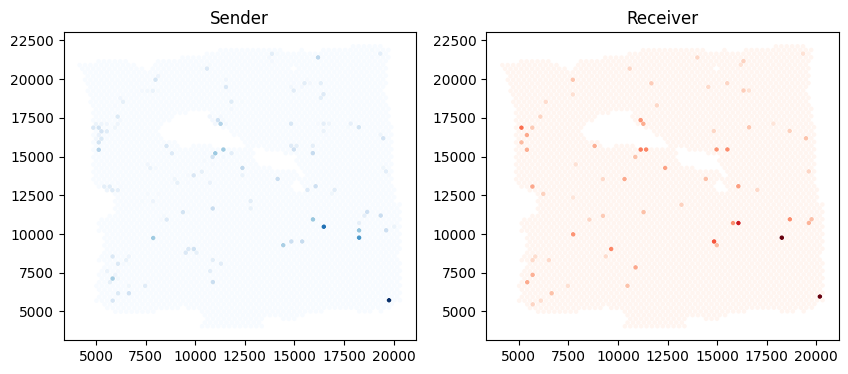

In [12]:
pts = adata.obsm['spatial']
s = adata.obsm['commot-user_database-sum-sender']['s-CD40_signaling_pathway']
r = adata.obsm['commot-user_database-sum-receiver']['r-CD40_signaling_pathway']
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(pts[:,0], pts[:,1], c=s, s=5, cmap='Blues')
ax[0].set_title('Sender')
ax[1].scatter(pts[:,0], pts[:,1], c=r, s=5, cmap='Reds')
ax[1].set_title('Receiver')

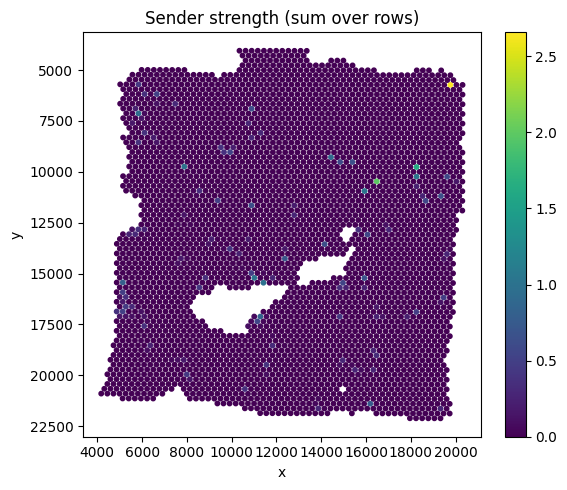

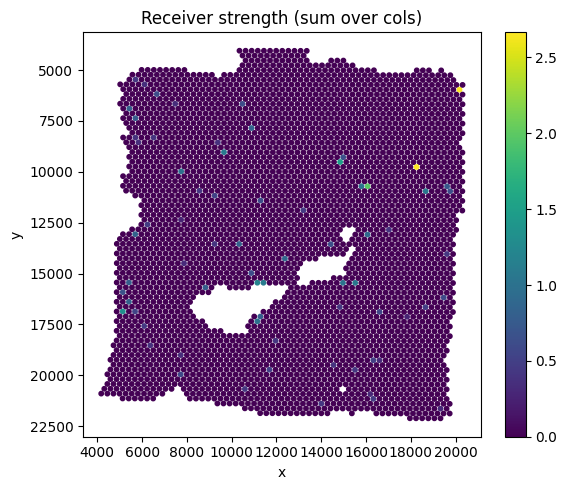

In [13]:
coords = np.asarray(adata.obsm["spatial"], float)

def plot_strength(xy, val, title, cmap="viridis"):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(xy[:,0], xy[:,1], c=val, s=10, cmap=cmap)
    plt.gca().invert_yaxis()
    plt.colorbar(sc)
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout(); plt.show()

plot_strength(coords, s, "Sender strength (sum over rows)")
plot_strength(coords, r, "Receiver strength (sum over cols)")